In [ ]:
#run this cell only the first time (if you run the notebook locally)
pip install neurokit2

In [ ]:
pip install pyPPG

In [ ]:
pip install matplotlib

In [ ]:
pip install --upgrade pip

In [ ]:
pip install heartpy

Run the above only the first time!

In [2]:
import warnings
from neurokit2 import NeuroKitWarning

# Attempt to suppress specific neurokit warnings globally
warnings.filterwarnings('ignore', category=NeuroKitWarning)

In [3]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#This is old data (possibly with 25Hz sampling rate) - DO NOT USE

file_path = "C:/Users/nikol/Desktop/University/8th_semester/biomedical_technologies/data_3/2024-04-22_16-49-57-721143_PG.csv"
data = pd.read_csv(file_path, skiprows=[1, 2]) #because the first 3 ech time have the same timestamp
data.head(10)

In [17]:
# This is simulated data (too perfect to be real)

file_path = "C:/Users/nikol/Downloads/rrest-syn_csv/rrest-syn_csv/rrest-syn189_data.csv"
perfect_data = pd.read_csv(file_path)
perfect_data.columns = ['PG', 'Timestamp']
perfect_data.head(5)

,PG,Timestamp
0,0.003844,62.893
1,0.011902,62.396
2,0.026986,59.875
3,0.048959,59.399
4,0.078713,60.240


In [14]:
#This is new data 18-10-24 (100Hz sampling rate)

file_path = "C:/Users/nikol/Desktop/unity/project_biomed/mindscape/hrv_analysis/sd_data/100hz_18-10-24/2024-10-18_12-48-08-471817_PG.csv"
data = pd.read_csv(file_path, skiprows=[1, 2]) #because the first 3 ech time have the same timestamp
data.head(5)

,LocalTimestamp,EmotiBitTimestamp,PacketNumber,DataLength,TypeTag,ProtocolVersion,DataReliability,PG
0,1.729245e+09,263816.000,36885,3,PG,1,100,9451
1,1.729245e+09,263825.727,36889,11,PG,1,100,9447
2,1.729245e+09,263835.455,36889,11,PG,1,100,9473
3,1.729245e+09,263845.182,36889,11,PG,1,100,9432
4,1.729245e+09,263854.909,36889,11,PG,1,100,9449


In [18]:
ppg_signal = data['PG']
perfect_ppg_signal = perfect_data['PG']
ppg_signal.head(5)

0    9451
1    9447
2    9473
3    9432
4    9449
Name: PG, dtype: int64

In [15]:
ppg_timestamp = data['EmotiBitTimestamp']
ppg_timestamp.head(5)

0    263816.000
1    263825.727
2    263835.455
3    263845.182
4    263854.909
Name: EmotiBitTimestamp, dtype: float64

RMSSD (Root Mean Square of Successive Differences)

#Relevance to Anxiety: 
RMSSD is a time-domain measure that primarily reflects parasympathetic (vagal) activity. Higher values generally indicate greater vagal tone, which is associated with relaxation and emotional regulation. Conversely, lower RMSSD values can indicate reduced vagal activity, which is often observed during stress or anxiety.

#Usefulness: 
RMSSD is very useful for short-term measurements and is sensitive to changes over shorter periods, making it suitable for real-time analysis in a gaming context.

In [20]:
# Assuming the EmotiBitTimestamp is in milliseconds and represents the sampling frequency
# Calculate sampling rate based on median diff
sampling_rate = 1000 / (ppg_timestamp.diff().median()) #~100hz
print("Emotibit Sampling Rate (Hz): ", sampling_rate)

perfect_sampling_rate = 500
print("Perfect Signal Sampling Rate (Hz): ", perfect_sampling_rate)


window_size = int(30 * sampling_rate)  # 30 seconds window

step_size = int(5 * sampling_rate)  # 10 seconds step (how often hrv is updated)

Emotibit Sampling Rate (Hz):  102.79605263154943
Perfect Signal Sampling Rate (Hz):  500


In [49]:
#The implementation of the functions used to filter the PPG signal
#and detect the peaks

import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fft import fft

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

def detect_peaks(data, lowcut, highcut, fs, order, peak_distance):
    filtered_signal = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    
    # Ensure data is a NumPy array for FFT
    data = np.asarray(data)  # Convert to NumPy array if not already
    freq_domain_signal = fft(data) # Perform FFT to convert signal to frequency domain
    
    peaks, _ = find_peaks(filtered_signal, distance=peak_distance)
    return peaks, filtered_signal, freq_domain_signal

def detect_peaks2(data, fs):
    working_data, measures = hp.process(data, sample_rate=fs)
    peaks = working_data['peaklist']
    return peaks

def calculate_rmssd(rr_intervals):
    if len(rr_intervals) > 1:
        rr_diff = np.diff(rr_intervals)
        rr_diff_squared = np.square(rr_diff)
        mean_rr_diff_squared = np.mean(rr_diff_squared)
        rmssd = np.sqrt(mean_rr_diff_squared) * 1000  # Convert from seconds to milliseconds
        return rmssd
    else:
        return None

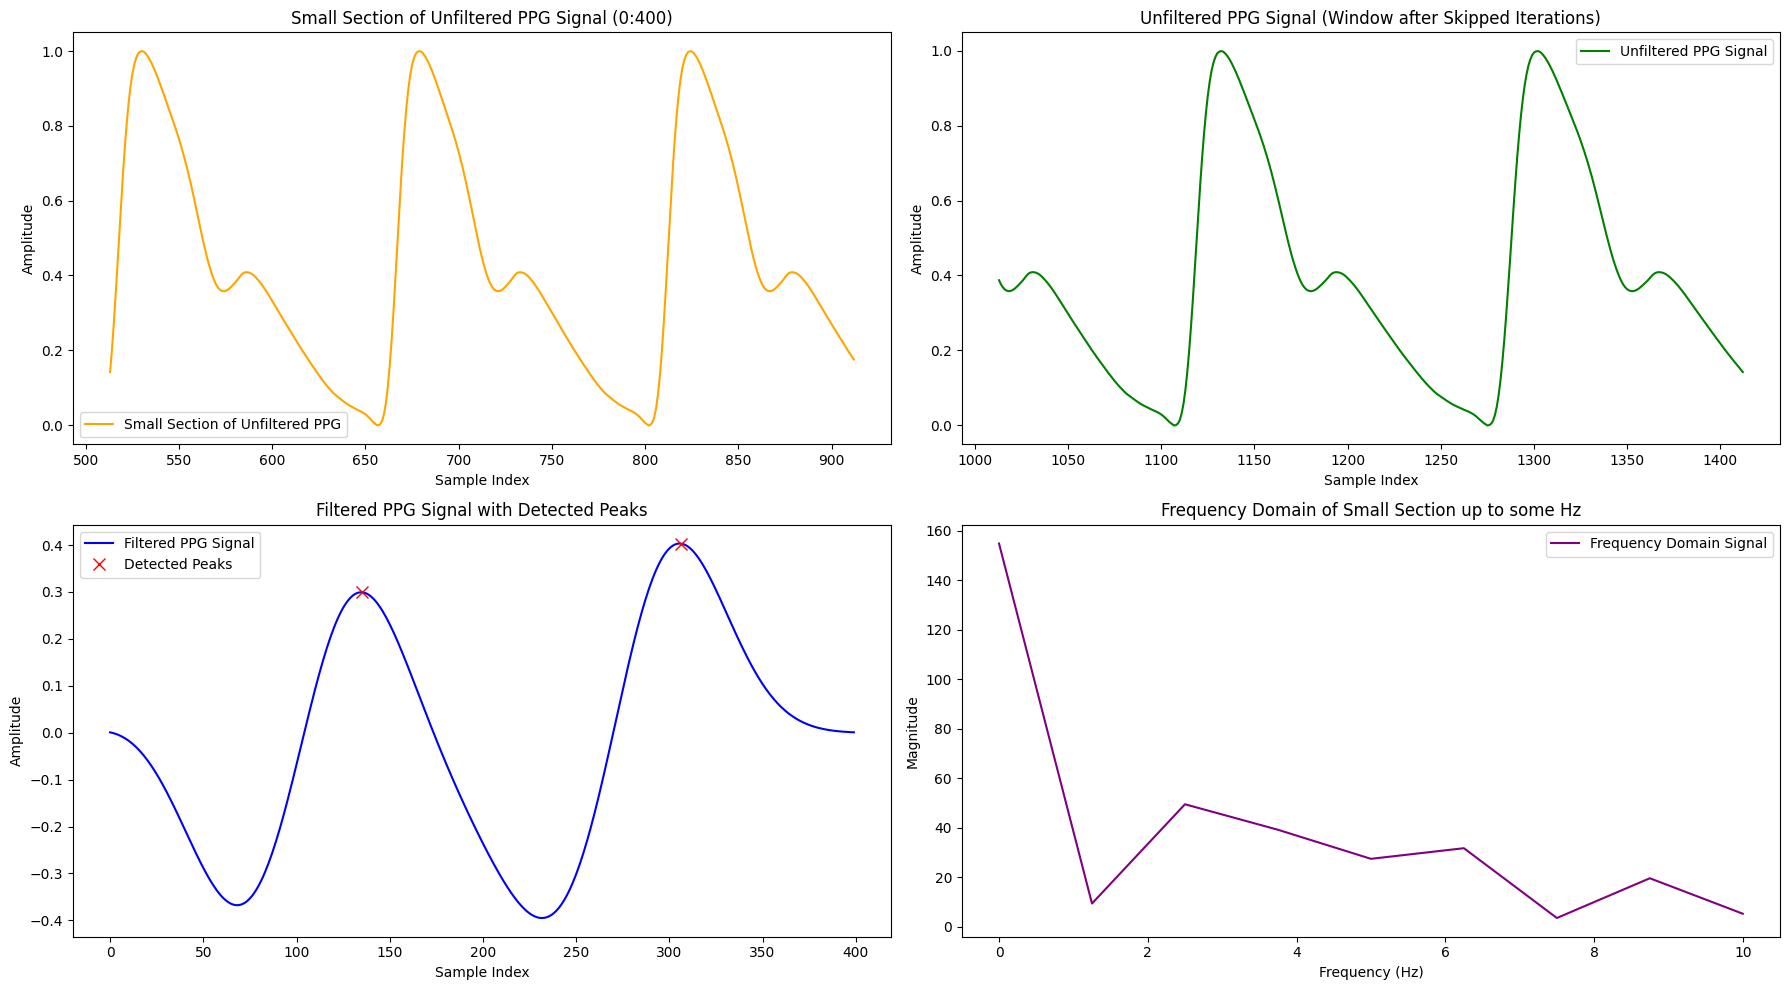

In [83]:
#This is the ppg analysis and peak detection for the perfect signal

import matplotlib.pyplot as plt

#filter parameters
lowcut = 0.5  
highcut = 5
fs = 500
order = 3
peak_distance = 2
#minimum number of samples between two peaks 
#(for 60BPM or 1 beat per second we have 100 samples)

# Define how many iterations (windows) you want to skip
skip_iterations = 1

# Start processing after skipping the specified number of iterations
for iteration, start in enumerate(range(0, len(ppg_signal), step_size)):
    end = start + window_size
    if end > len(ppg_signal):
        break

    if iteration < skip_iterations:
        continue

    chunk = perfect_ppg_signal[start:end]
    small_chunk = chunk[500:900]
    peaks, filtered_signal, freq_domain_signal = detect_peaks(small_chunk, lowcut, highcut, fs, order, peak_distance)
    #peaks, filtered_signal = detect_peaks(chunk, lowcut, highcut, fs, order, peak_distance)
    
        # Plot a small section of the unfiltered signal first
    plt.figure(figsize=(18, 10))

    # Plot a small section of the unfiltered signal (samples 0-400)
    plt.subplot(2, 2, 1)  # Add first subplot for small section of unfiltered chunk
    plt.plot(chunk[0:400], label="Small Section of Unfiltered PPG", color="orange")
    plt.title("Small Section of Unfiltered PPG Signal (0:400)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the unfiltered signal (entire small chunk)
    plt.subplot(2, 2, 2)
    plt.plot(small_chunk, label="Unfiltered PPG Signal", color="green")
    plt.title("Unfiltered PPG Signal (Window after Skipped Iterations)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the filtered PPG signal with detected peaks
    plt.subplot(2, 2, 3) 
    plt.plot(filtered_signal, label="Filtered PPG Signal", color="blue")
    plt.plot(peaks, filtered_signal[peaks], "rx", label="Detected Peaks", markersize=8)
    plt.title("Filtered PPG Signal with Detected Peaks")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the frequency domain signal for the small_chunk limited to some Hz
    freqs = np.fft.fftfreq(len(small_chunk), 1/fs)
    
    # Select only frequencies up to some Hz
    mask = (freqs >= 0) & (freqs <= 10)
    plt.subplot(2, 2, 4)
    plt.plot(freqs[mask], np.abs(freq_domain_signal[mask]), label="Frequency Domain Signal", color="purple")
    plt.title("Frequency Domain of Small Section up to some Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

    plt.tight_layout()
    plt.show()


    break 


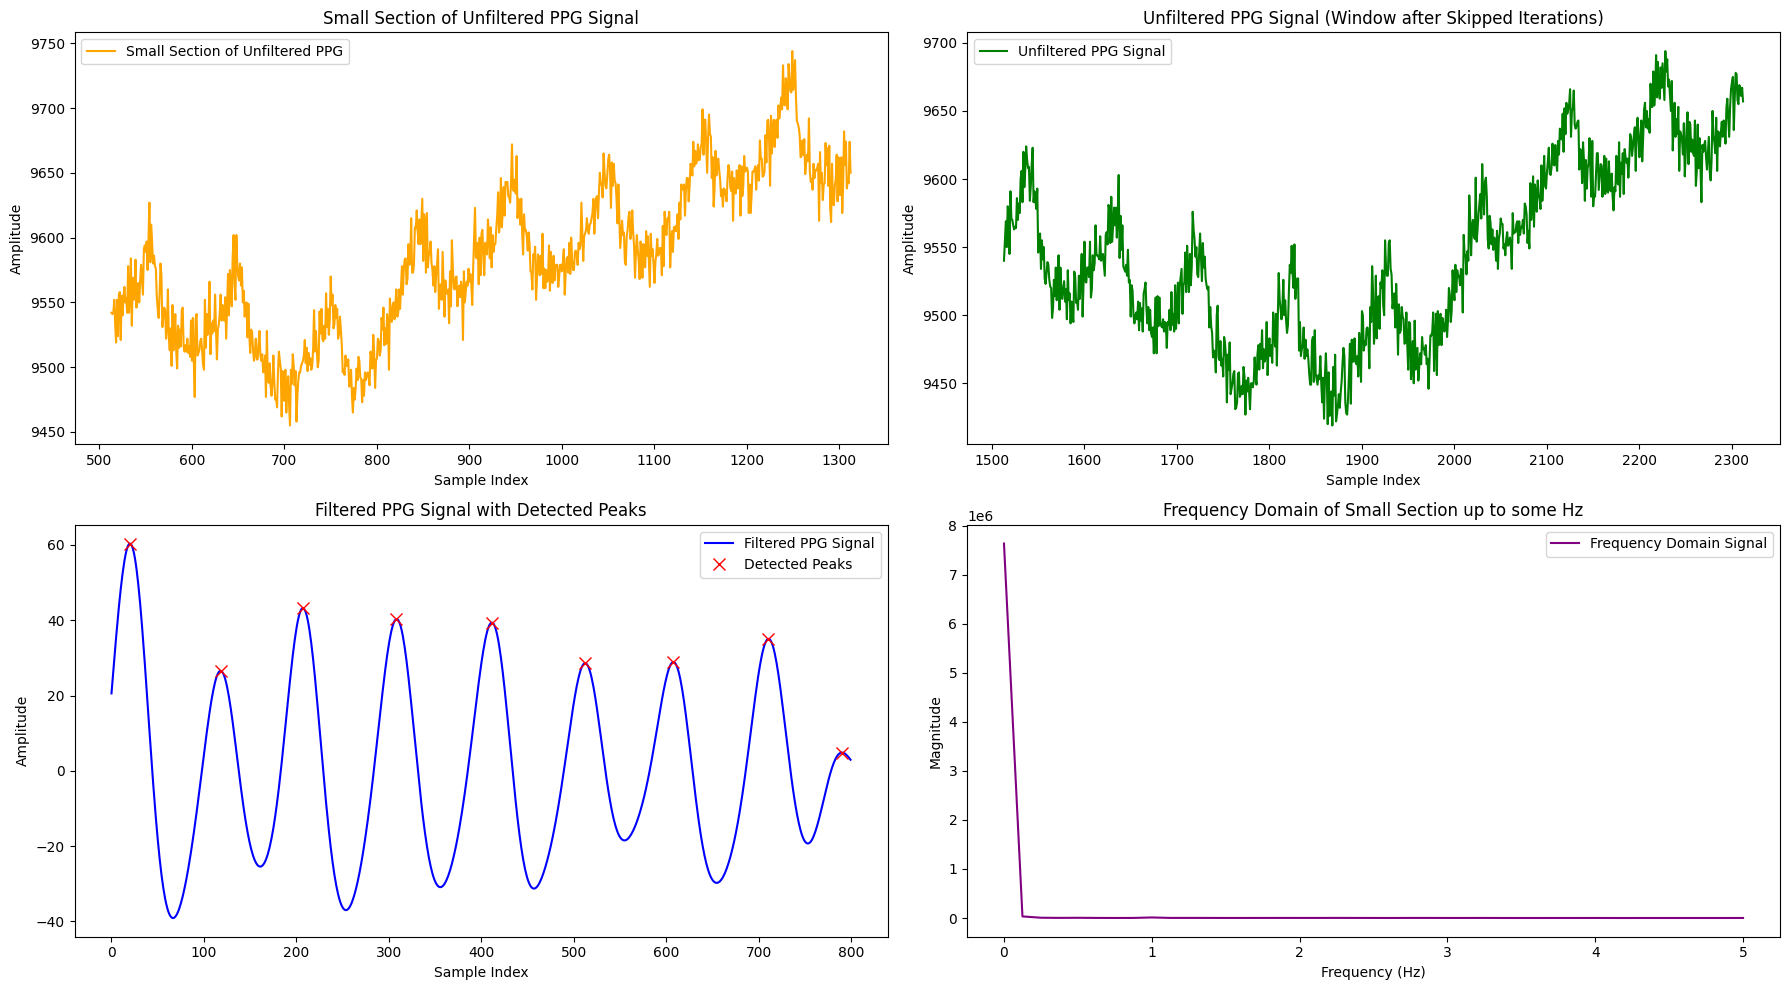

In [100]:
#This is the ppg analysis and peak detection for the emotibit signal

import matplotlib.pyplot as plt

#filter parameters
lowcut = 0.5
highcut = 2
fs = 100
order = 3
peak_distance = 20
#minimum number of samples between two peaks 
#(for 60BPM or 1 beat per second we have 100 samples)
#we consider maxBPM to be 220 or 3.6 beats per second so 100/3.67=27.2 samples

# Define how many iterations (windows) you want to skip
skip_iterations = 1

# Start processing after skipping the specified number of iterations
for iteration, start in enumerate(range(0, len(ppg_signal), step_size)):
    end = start + window_size
    if end > len(ppg_signal):
        break

    if iteration < skip_iterations:
        continue

    chunk = ppg_signal[start:end]
    small_chunk = chunk[1000:1800]
    peaks, filtered_signal, freq_domain_signal = detect_peaks(small_chunk, lowcut, highcut, fs, order, peak_distance)
    #peaks, filtered_signal = detect_peaks(chunk, lowcut, highcut, fs, order, peak_distance)
    
    # Plot a small section of the unfiltered signal first
    plt.figure(figsize=(18, 10))

    # Plot a small section of the unfiltered signal (samples 0-400)
    plt.subplot(2, 2, 1)  # Add first subplot for small section of unfiltered chunk
    plt.plot(chunk[0:800], label="Small Section of Unfiltered PPG", color="orange")
    plt.title("Small Section of Unfiltered PPG Signal")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the unfiltered signal (entire small chunk)
    plt.subplot(2, 2, 2)
    plt.plot(small_chunk, label="Unfiltered PPG Signal", color="green")
    plt.title("Unfiltered PPG Signal (Window after Skipped Iterations)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the filtered PPG signal with detected peaks
    plt.subplot(2, 2, 3) 
    plt.plot(filtered_signal, label="Filtered PPG Signal", color="blue")
    plt.plot(peaks, filtered_signal[peaks], "rx", label="Detected Peaks", markersize=8)
    plt.title("Filtered PPG Signal with Detected Peaks")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the frequency domain signal for the small_chunk limited to some Hz
    freqs = np.fft.fftfreq(len(small_chunk), 1/fs)
    
    # Select only frequencies up to some Hz
    mask = (freqs >= 0) & (freqs <= 5)
    plt.subplot(2, 2, 4)
    plt.plot(freqs[mask], np.abs(freq_domain_signal[mask]), label="Frequency Domain Signal", color="purple")
    plt.title("Frequency Domain of Small Section up to some Hz")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

    plt.tight_layout()
    plt.show()


    break 


For the first dataset these parameters that i selected below have RMSSD around 66
For the second dataset the have around 121
(selected based on the list above from testing many parameters)

In [12]:
buffer = np.array([])  # Buffer to store windowed data
baseline_hrv = []  # List to store baseline HRV values

num_steps_for_baseline = 12
current_step = 0
current_timestamp = 0

# Loop over the signal in chunks
for start in range(0, len(ppg_signal), step_size):
    end = start + window_size
    chunk = ppg_signal[start:end]
    buffer = np.concatenate((buffer, chunk))[-window_size:]  # Keep the last 'window_size' samples

    # Process the PPG signal to find peaks and calculate HRV
    if len(buffer) >= window_size:
        signals, info = nk.ppg_process(buffer, sampling_rate=sampling_rate)
        rpeaks = info['PPG_Peaks']
        peaks, filtered_signal = detect_peaks(buffer, lowcut=1.0, highcut=1.8, fs=25, order=3, peak_distance=2.272)
        print(f"My peaks: {peaks}\n")
        #print(f"Neurokit peaks: {rpeaks}\n")
        #hrv_indices = nk.hrv(peaks, sampling_rate=sampling_rate, show=False, domain=["time", "frequency"])
        #current_hrv = hrv_indices['HRV_RMSSD'].iloc[0]  # Extract RMSSD
        #hrv_indices2 = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False, domain=["time", "frequency"])
        #current_hrv2 = hrv_indices2['HRV_RMSSD'].iloc[0]  # Extract RMSSD
        rr_intervals = np.diff(peaks) / sampling_rate
        current_hrv = calculate_rmssd(rr_intervals)
        rr_intervals2 = np.diff(rpeaks) / sampling_rate
        current_hrv2 = calculate_rmssd(rr_intervals2)
        
        current_step += 1  # Increment the step counter
        current_timestamp += 5
        if current_step < 6:
            print(f"Segment {current_step} skipped.")
            print(f"    Current HRV: {current_hrv}")
            print(f"    Current HRV (Neurokit): {current_hrv2}\n")
            if current_step == 5:
                print("\n")
            
        elif current_step <= num_steps_for_baseline:
            baseline_hrv.append(current_hrv)  # Collect HRV values for baseline
            print(f"Segment {current_step} - Timestamp {current_timestamp//60}min {current_timestamp%60}sec:")
            print(f"    Current HRV: {current_hrv}")
            print(f"    Current HRV (Neurokit): {current_hrv2}\n")
            if current_step == num_steps_for_baseline:
                # Calculate average baseline HRV after collecting enough data
                baseline_hrv = np.mean(baseline_hrv)
                print(f"Baseline HRV established: {baseline_hrv}\n\n\n")
                
        else:
            # Compare to baseline and previous HRV
            change_from_baseline = (current_hrv - baseline_hrv) / baseline_hrv * 100
            change_from_previous = (current_hrv - previous_hrv) / previous_hrv * 100 if 'previous_hrv' in locals() else 0
            print(f"Segment {current_step} - Timestamp {current_timestamp//60}min {current_timestamp%60}sec:")
            print(f"  Current HRV: {current_hrv}")
            print(f"    Current HRV (Neurokit): {current_hrv2}\n")
            print(f"  Change from Baseline: {change_from_baseline:.2f}%")
            print(f"  Change from Previous: {change_from_previous:.2f}%\n")
        # Store current HRV as previous HRV for the next iteration
        previous_hrv = current_hrv

My peaks: [  3  16  36  58  80 101 129 149 171 192 213 235 258 280 303 322 341 367
 393 417 439 465 486 509 534 555 578 599 623 646 669 692 714 735]

Segment 1 skipped.
    Current HRV: 129.2284798332009
    Current HRV (Neurokit): 837.8327018943797

My peaks: [  5  24  46  67  88 110 133 155 178 197 216 242 268 292 314 340 361 384
 409 430 453 474 498 521 544 567 589 613 634 658 680 706 728 748]

Segment 2 skipped.
    Current HRV: 107.93516572461454
    Current HRV (Neurokit): 854.8175498188258

My peaks: [  7  30  53  72  91 117 143 167 189 215 236 259 284 305 328 349 373 396
 419 442 464 488 509 533 555 580 603 625 647 669 695 714 724 743]

Segment 3 skipped.
    Current HRV: 145.60219778561037
    Current HRV (Neurokit): 950.9894596581776

My peaks: [ 19  42  64  90 111 134 159 180 203 224 248 271 294 317 339 363 384 408
 430 455 478 500 522 544 570 590 598 618 642 666 690 714 734]

Segment 4 skipped.
    Current HRV: 160.1612091089032
    Current HRV (Neurokit): 899.3542657029516

My peaks: [ 12  33  55  81 102 127 148 172 193 216 237 258 278 296 313 331 350 376
 399 425 450 475 501 525 548 571 593 613 633 653 671 688 707 720 735]

Segment 32 - Timestamp 2min 40sec:
  Current HRV: 106.96926774744345
    Current HRV (Neurokit): 435.4964326571951

  Change from Baseline: -20.93%
  Change from Previous: -3.23%

My peaks: [  4  23  48  68  91 112 133 153 171 188 206 225 251 274 300 325 350 376
 400 423 446 468 488 508 528 546 563 582 594 610 634 661 683 710 735]

Segment 33 - Timestamp 2min 45sec:
  Current HRV: 132.4821314423766
    Current HRV (Neurokit): 504.74669961202403

  Change from Baseline: -2.07%
  Change from Previous: 23.85%

My peaks: [  7  28  46  63  81 100 126 149 175 200 225 251 275 298 321 343 363 383
 403 421 438 457 469 485 509 536 558 586 610 634 657 678 699 717 734]

Segment 34 - Timestamp 2min 50sec:
  Current HRV: 126.4911064067352
    Current HRV (Neurokit): 531.5035277399389

  Change from Baseline: -6.50%
  Change from Previous: -4.52%

M

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FROM NOW ON THERE ARE TESTING CELLS
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
FROM NOW ON THERE ARE TESTING CELLS
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [15]:
buffer = np.array([])
baseline_hrv = []
num_steps_for_baseline = 15
current_step = 0


# Loop over the signal in chunks
for start in range(0, len(ppg_signal), step_size):
    end = start + window_size
    chunk = ppg_signal[start:end]
    buffer = np.concatenate((buffer, chunk))[-window_size:]  # Keep the last 'window_size' samples

    if len(buffer) >= window_size:
        #signals, info = nk.ppg_process(buffer, sampling_rate=25)
        #rpeaks = info['PPG_Peaks']
        #print(f"Neurokit peaks: {rpeaks}")
        #peaks, filtered_signal = detect_peaks(buffer, fs)
        #peaks, filtered_signal = detect_peaks(buffer, lowcut=1.0, highcut=2.0, fs=25, order=4, peak_distance=10.0)
        peaks, filtered_signal = detect_peaks(buffer, lowcut=1.0, highcut=1.8, fs=25, order=3, peak_distance=2.272)
        print(f"My peaks: {peaks}\n")

        # Convert peak indices to time in seconds to get RR intervals
        #rr_intervals = np.diff(peaks) / sampling_rate
        #current_hrv = calculate_rmssd(rr_intervals)
        hrv_indices = nk.hrv(peaks, sampling_rate=sampling_rate, show=False, domain=["time", "frequency"])
        #hrv_indices = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False, domain=["time", "frequency"])
        current_hrv = hrv_indices['HRV_RMSSD'].iloc[0]  # Extract RMSSD
        #print(f"Neurokit current_hrv: {current_hrv_2}")
        print(f"My current_hrv: {current_hrv}\n")

        current_step += 1  # Increment the step counter

        if current_hrv is not None:
            if current_step <= num_steps_for_baseline:
                baseline_hrv.append(current_hrv)  # Collect HRV values for baseline
                if current_step == num_steps_for_baseline:
                    # Calculate average baseline HRV after collecting enough data
                    baseline_hrv = np.mean(baseline_hrv)
                    print(f"Baseline HRV established: {baseline_hrv}\n")
            else:
                # Compare to baseline and previous HRV
                change_from_baseline = (current_hrv - baseline_hrv) / baseline_hrv * 100
                change_from_previous = (current_hrv - previous_hrv) / previous_hrv * 100 if 'previous_hrv' in locals() else 0
                print(f"Segment {current_step}:")
                print(f"  Current HRV: {current_hrv}")
                print(f"  Change from Baseline: {change_from_baseline:.2f}%")
                print(f"  Change from Previous: {change_from_previous:.2f}%\n")
            # Store current HRV as previous HRV for the next iteration
            previous_hrv = current_hrv


My peaks: [ 11  33  54  75  99 120 142 162 182 203 224 245 265 283 300 320 339 360
 381 403 422 442 464 487 507 528 550 573 594 612 629 649 670 694 717 740]

My hrv: 70.95980635294222

My peaks: [ 17  37  57  78  99 120 140 158 175 195 214 235 256 278 297 317 339 362
 382 403 425 448 469 487 504 524 545 569 591 616 636 656 676 698 719 737]

My hrv: 79.40958602675862

My peaks: [ 15  33  50  70  89 110 131 153 172 192 214 237 257 278 300 323 344 362
 379 399 420 444 466 491 511 531 551 573 594 613 633 652 671 691 713 731
 747]

My hrv: 82.80786712108251

My peaks: [  5  28  47  67  89 112 132 153 175 198 219 237 254 274 295 319 341 366
 386 406 426 448 469 488 508 527 546 567 588 606 624 644 666 687 707 725
 743]

My hrv: 80.85259956948111

My peaks: [  7  28  49  73  94 112 129 149 170 194 216 241 261 281 301 323 344 363
 383 402 421 442 463 481 499 519 541 562 582 599 617 637 658 677 695 712
 730 747]

My hrv: 79.44250191875324

My peaks: [  4  24  45  69  91 116 136 156 176 198 219 2

My hrv: 69.61116495013056

Segment 34:
  Current HRV: 69.61116495013056
  Change from Baseline: -4.19%
  Change from Previous: 5.48%

My peaks: [  9  27  45  65  85 103 124 145 165 187 207 227 247 266 288 309 329 350
 371 393 415 438 460 485 507 528 547 564 583 605 626 649 670 693 717 736]

My hrv: 75.45937746270388

Segment 35:
  Current HRV: 75.45937746270388
  Change from Baseline: 3.86%
  Change from Previous: 8.40%

My peaks: [ 19  39  62  82 102 122 141 163 184 204 225 246 268 290 313 335 360 382
 403 422 439 458 480 501 524 545 568 591 612 633 652 670 691 713 734]

My hrv: 72.0269309902816

Segment 36:
  Current HRV: 72.0269309902816
  Change from Baseline: -0.86%
  Change from Previous: -4.55%

My peaks: [ 16  38  59  79 100 121 143 165 188 210 235 257 278 297 314 333 355 376
 399 420 443 466 487 508 527 545 566 588 612 637 659 682 704 727 746]

My hrv: 73.36087637029823

Segment 37:
  Current HRV: 73.36087637029823
  Change from Baseline: 0.97%
  Change from Previous: 1.85%

M

C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


My hrv: 87.85013977691516

Segment 42:
  Current HRV: 87.85013977691516
  Change from Baseline: 20.92%
  Change from Previous: 2.08%

My peaks: [  4  21  40  58  80  98 116 133 151 170 190 209 225 242 261 283 306 329
 351 375 395 416 433 450 468 492 516 541 567 591 615 637 659 678 695 713
 731 747]

My hrv: 86.66666666666667

Segment 43:
  Current HRV: 86.66666666666667
  Change from Baseline: 19.29%
  Change from Previous: -1.35%

My peaks: [  6  26  45  65  84 100 117 136 158 181 204 226 250 270 291 308 325 343
 367 391 416 442 466 490 512 534 553 570 587 606 628 652 677 701 724 744]

My hrv: 85.12965889470844

Segment 44:
  Current HRV: 85.12965889470844
  Change from Baseline: 17.17%
  Change from Previous: -1.77%

My peaks: [ 12  33  56  79 101 125 145 166 183 200 218 242 266 291 317 341 365 387
 409 428 445 462 481 503 527 552 576 598 621 642 663 683 701 717 735]

My hrv: 83.2666399786453

Segment 45:
  Current HRV: 83.2666399786453
  Change from Baseline: 14.61%
  Change from Pr

C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
C:\Users\nikol\anaconda3\lib\site-packages\neurokit2\complexity\entropy_multisca

My hrv: 74.20163308810108

Segment 46:
  Current HRV: 74.20163308810108
  Change from Baseline: 2.13%
  Change from Previous: -10.89%

My peaks: [ 17  42  67  91 115 137 159 178 195 212 231 253 277 302 326 348 371 392
 413 433 451 467 484 503 523 545 567 589 611 633 654 672 690 710 728 746]

My hrv: 62.497058754322005

Segment 47:
  Current HRV: 62.497058754322005
  Change from Baseline: -13.98%
  Change from Previous: -15.77%

My peaks: [ 14  34  53  70  88 106 128 152 177 201 223 246 267 288 308 326 342 359
 378 398 420 442 464 486 508 529 547 565 585 603 621 640 660 681 700 719
 739]

My hrv: 61.22557822161771

Segment 48:
  Current HRV: 61.22557822161771
  Change from Baseline: -15.73%
  Change from Previous: -2.03%

My peaks: [  5  28  52  76  98 121 142 163 183 201 217 234 253 273 295 317 339 361
 383 404 422 440 460 478 496 515 535 556 575 593 614 632 651 669 687 705
 722 739]

My hrv: 58.11865258054232

Segment 49:
  Current HRV: 58.11865258054232
  Change from Baseline: -20.01

In [ ]:
buffer = np.array([])  # Buffer to store windowed data
baseline_hrv = []  # List to store baseline HRV values

num_steps_for_baseline = 15
current_step = 0

# Loop over the signal in chunks
for start in range(0, len(ppg_signal), step_size):
    end = start + window_size
    chunk = ppg_signal[start:end]
    buffer = np.concatenate((buffer, chunk))[-window_size:]  # Keep the last 'window_size' samples

    # Process the PPG signal to find peaks and calculate HRV
    if len(buffer) >= window_size:
        signals, info = nk.ppg_process(buffer, sampling_rate=sampling_rate)
        rpeaks = info['PPG_Peaks']
        hrv_indices = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False, domain=["time", "frequency"])
        if current_step == 0:
            print(hrv_indices)
            print(rpeaks)
        current_hrv = hrv_indices['HRV_RMSSD'].iloc[0]  # Extract RMSSD

        current_step += 1  # Increment the step counter

        if current_step <= num_steps_for_baseline:
            baseline_hrv.append(current_hrv)  # Collect HRV values for baseline
            if current_step == num_steps_for_baseline:
                # Calculate average baseline HRV after collecting enough data
                baseline_hrv = np.mean(baseline_hrv)
                print(f"Baseline HRV established: {baseline_hrv}\n")
                
        else:
            # Compare to baseline and previous HRV
            change_from_baseline = (current_hrv - baseline_hrv) / baseline_hrv * 100
            change_from_previous = (current_hrv - previous_hrv) / previous_hrv * 100 if 'previous_hrv' in locals() else 0
            print(f"Segment {current_step}:")
            print(f"  Current HRV: {current_hrv}")
            print(f"  Change from Baseline: {change_from_baseline:.2f}%")
            print(f"  Change from Previous: {change_from_previous:.2f}%\n")
        # Store current HRV as previous HRV for the next iteration
        previous_hrv = current_hrv

In [ ]:
# Load your data here
# data = pd.read_csv('path_to_ppg_data.csv')
# ppg_signal = data['PPG'].values
fs = 25  # Example sampling rate

# Define your parameters
parameter_sets = [
    (0.5, 3.5, 4, fs/2),
    (0.5, 4.0, 4, fs/2.5),
    (1.0, 4.0, 4, fs/2),
    (0.5, 5.0, 3, fs/2),
    (0.5, 5.0, 5, fs/2),
    (1.0, 5.0, 3, fs/2),
    (1.0, 3.5, 5, fs/2),
    (0.5, 4.5, 4, fs/3),
    (0.7, 4.0, 3, fs/2.5),
    (0.7, 4.0, 5, fs/2),
    (0.8, 2.5, 3, fs/2.5),  # Narrower band, moderate distance
    (0.8, 3.0, 3, fs/2),    # Slightly wider highcut
    (0.8, 2.5, 4, fs/2),    # Higher order filter
    (1.0, 3.0, 4, fs/2.2),  # Balanced approach with moderate order
    (0.7, 2.5, 3, fs/2.5),  # Lower lowcut
    (1.0, 2.5, 5, fs/3),    # High order with narrower band
    (0.8, 2.8, 3, fs/2.3),  # Minor adjustment in band and distance
    (0.8, 3.0, 2, fs/2.5),  # Lower order to see the filter's impact
    (0.9, 2.5, 4, fs/2),    # Slightly higher lowcut with moderate highcut
    (0.9, 3.0, 5, fs/2.1),   # Highest order with wider band
    (1.2, 2.0, 3, fs/3),   # More conservative frequency range, tighter peak spacing
    (1.2, 2.5, 3, fs/2.8), # Moderate upper frequency with closer peaks
    (1.0, 2.0, 4, fs/2.5), # Higher order for sharper cutoff, tighter peak detection
    (1.0, 2.0, 2, fs/2.5), # Lower order to test less aggressive slope
    (1.2, 2.2, 3, fs/3),   # Narrow band to focus on primary heart rate frequencies
    (1.1, 2.3, 4, fs/3),   # Slightly broader band with higher filter order
    (1.0, 2.5, 5, fs/2.7), # High order with moderately tight peak detection
    (1.1, 2.0, 3, fs/2.8), # Very conservative frequency band
    (1.3, 2.5, 4, fs/3.2), # Higher lowcut with tighter peak detection
    (1.1, 2.1, 3, fs/2.6),  # Specific adjustment to see effects of slight frequency tweaks
    (1.1, 1.9, 4, 25/12),  # Lower highcut with high order and tighter peak distance
    (1.0, 1.8, 3, 25/11),  # Even lower highcut for stringent noise filtration
    (1.1, 2.0, 2, 25/10),  # Lower order to see if it reduces erroneous peak detection
    (1.0, 1.9, 5, 25/10),  # High order for sharp cutoff at a slightly higher lowcut
    (1.2, 2.0, 4, 25/9.5), # Slightly broader band with higher filter order and moderate distance
    (1.0, 1.8, 4, 25/11.5),# A tight band with high order and closer peak spacing
    (1.1, 2.0, 5, 25/12),  # High order with moderate highcut and tighter peak detection
    (1.2, 1.9, 3, 25/10.5),# Narrow band with lower order and tighter peak detection
    (1.1, 2.1, 3, 25/11),  # Mid-range settings to test the impact of slight adjustments
    (1.0, 1.9, 4, 25/12)   # A balanced approach with strict settings for realistic HRV
]


In [66]:
hrv_results = []

for lowcut, highcut, order, peak_distance in parameter_sets:
    current_hr_values = []
    for start in range(0, len(ppg_signal), step_size):
        end = start + window_size
        if end > len(ppg_signal):
            break
        chunk = ppg_signal[start:end]
        peaks, filtered_signal = detect_peaks(chunk, lowcut, highcut, fs, order, peak_distance)
        rr_intervals = np.diff(peaks) / fs
        current_hrv = calculate_rmssd(rr_intervals)
        if current_hrv is not None:
            current_hr_values.append(current_hrv)

    mean_hrv = np.mean(current_hr_values) if current_hr_values else None
    hrv_results.append((lowcut, highcut, order, peak_distance, mean_hrv))

for result in hrv_results:
    print(f"Parameters: Lowcut={result[0]}, Highcut={result[1]}, Order={result[2]}, Distance={result[3]}, Mean HRV={result[4]}")


Parameters: Lowcut=0.5, Highcut=3.5, Order=4, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=0.5, Highcut=4.0, Order=4, Distance=10.0, Mean HRV=83.84078267919197
Parameters: Lowcut=1.0, Highcut=4.0, Order=4, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=0.5, Highcut=5.0, Order=3, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=0.5, Highcut=5.0, Order=5, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=1.0, Highcut=5.0, Order=3, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=1.0, Highcut=3.5, Order=5, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=0.5, Highcut=4.5, Order=4, Distance=8.333333333333334, Mean HRV=83.84078267919197
Parameters: Lowcut=0.7, Highcut=4.0, Order=3, Distance=10.0, Mean HRV=83.84078267919197
Parameters: Lowcut=0.7, Highcut=4.0, Order=5, Distance=12.5, Mean HRV=83.84078267919197
Parameters: Lowcut=0.8, Highcut=2.5, Order=3, Distance=10.0, Mean HRV=83.84078267919197
Parameters: Lowcut=